# Simulating lightcurves for SNe Ia

In [4]:
import warnings
## No annoying warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey.cadence as simul

import simsurvey_tools as sst

In [5]:
# Load ZTF fields from file (This function will soon be redundant 
# because the ztf_sim now contains the fields) 
fields = sst.load_ztf_fields()

# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently DES filters are used as proxies for ZTF filters
plan = simul.SurveyPlan(fields=fields, load_opsim='/home/ufeindt/data/ZTF/one_year_sim_incomplete.db', 
                        band_dict={'g': 'desg', 'r': 'desr'})

mjd_range = (plan.cadence['time'].min(), plan.cadence['time'].max())

In [8]:
tr = simul.get_sn_generator([0.,0.2], ratekind="basic", 
                            dec_range=[-30,90],
                            mjd_range=[mjd_range[0] - 60, mjd_range[-1] + 24])

In [9]:
instprop = {"desg":{"gain":1.,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1.,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)
    
lcs = survey.get_lightcurves(
    # This cell may give an error because of the progress bar widget.
    # Just delete the following line to fix this.
    progress_bar=True, notebook=True
)

Determining field IDs for all objects

Generating lightcurves



In [10]:
lcs[0]

time,band,flux,fluxerr,zp,zpsys
float64,str4,float64,float64,int64,str2
57393.3367347,desg,105351.401364,1098.3178247,30,ab
57393.3371977,desg,104721.669058,1098.31662263,30,ab
57393.3761269,desg,104683.365318,589.223892059,30,ab
57393.3765899,desg,104773.807038,589.221649873,30,ab
57393.4082537,desr,129950.109529,697.26688942,30,ab
57393.4087167,desr,131604.970264,697.264440192,30,ab
57393.4478847,desr,128416.770466,627.369979882,30,ab
57393.4483477,desr,129012.038648,627.367258628,30,ab
57394.4826671,desg,98710.7969399,434.658749964,30,ab


## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Below are some examples how to assess survey statistics based on this.

The first skyplot shows all SNe that were active when a field was observed (but they may have been too faint to be detected). The second skyplot shows the SNe that had at least one $5\sigma$ detection. 

SNe pointed to: 27647 out of 33856


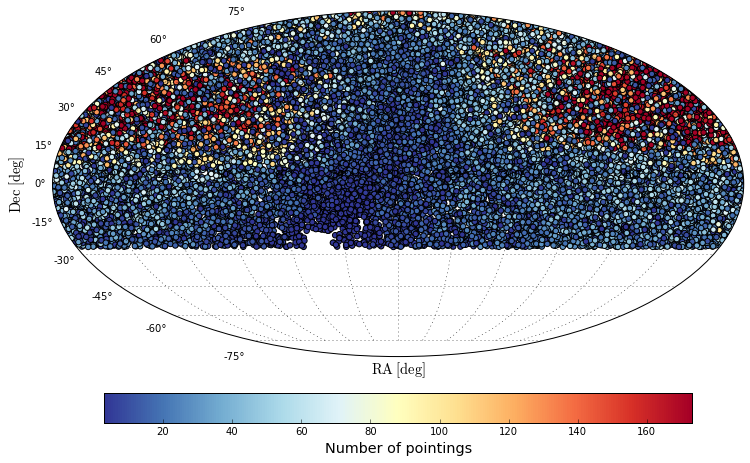

In [11]:
idx = lcs.meta['idx_orig']
n_obs = np.zeros(survey.generator.ntransient)
n_obs[idx] = np.array([len(a) for a in lcs])

survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of pointings", mask=idx)
print 'SNe pointed to: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

SNe detected: 17048 out of 33856


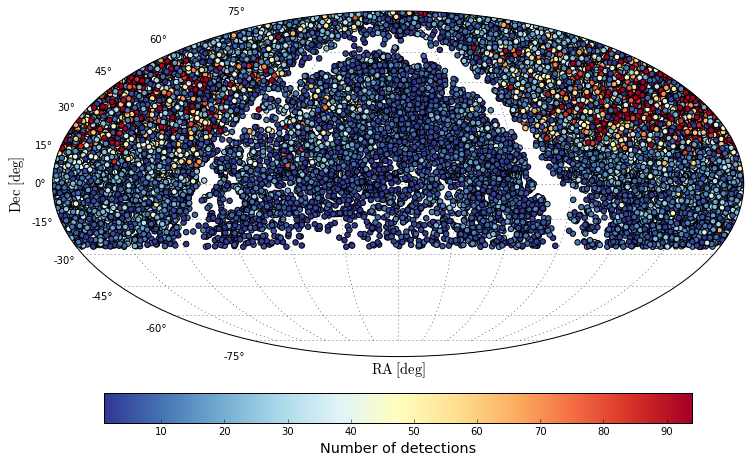

In [12]:
t_exp = -20

lcs_det = [lc[lc['flux']/lc['fluxerr'] > 5] for lc in lcs]
lcs_det = [lc[lc['time'] > t_exp*(1+lc.meta['z']) + lc.meta['t0']] for lc in lcs_det]

idx_det = lcs.meta['idx_orig'][np.array([len(lc) > 0 for lc in lcs_det])]
n_det = np.zeros(survey.generator.ntransient)
lcs_det = [lc for lc in lcs_det if len(lc) > 0]
n_det[idx_det] = np.array([len(a) for a in lcs_det])

survey.generator.show_skycoverage(cscale=n_det, cblabel="Number of detections", mask=idx_det)
print 'SNe detected: %i out of %i'%(np.sum(n_det > 0), survey.generator.ntransient)

In [13]:
z = np.array([lc.meta['z'] for lc in lcs_det])
p_i = np.array([lc['time'].min() - lc.meta['t0'] for lc in lcs_det])
p_e = np.array([lc['time'].max() - lc.meta['t0'] for lc in lcs_det])

The two last figures show how early the SNe are detected and at what redshift.

SNe found before peak: 12124


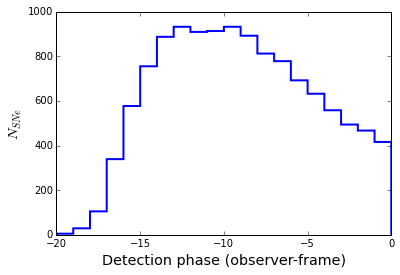

In [14]:
plt.hist(p_i, lw=2, histtype='step', range=(-20,0), bins=20)
print 'SNe found before peak:', np.sum(p_i < 0)
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')

SNe found 14 observer-frame days before peak: 1810
Local SNe (z < 0.1) found 14 observer-frame days before peak: 627


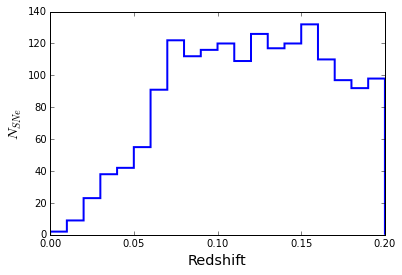

In [15]:
p_lim = -14
n = np.array([len(lc) for lc in lcs_det])
snr_max = np.array([max(lc['flux']/lc['fluxerr']) for lc in lcs_det])
plt.hist(z[(p_i < p_lim) & (snr_max >= 10)], lw=2, histtype='step', range=(0,0.2),bins=20)
print 'SNe found 14 observer-frame days before peak:', np.sum(p_i < p_lim) 
print 'Local SNe (z < 0.1) found 14 observer-frame days before peak:', np.sum((p_i < p_lim) & (z < 0.1))
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
_ = plt.xlim((0, 0.2))